In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import re
import json
import os
import csv

## 1. 데이터 로딩

In [1]:
# 각자의 데이터 디렉토리
data_dir = './data/train/'

6807개의 영화 번호가 1번부터 119145으로 존재하는데 이를 1부터 시작하여 순차적으로 재할당

In [17]:
directors = pd.read_csv(data_dir+"directors.tsv", delimiter="\t")
genres = pd.read_csv(data_dir+"genres.tsv", delimiter="\t")
titles = pd.read_csv(data_dir+"titles.tsv", delimiter="\t")
writers = pd.read_csv(data_dir+"writers.tsv", delimiter="\t")
years = pd.read_csv(data_dir+"years.tsv", delimiter="\t")

train = pd.read_csv(data_dir+"train_ratings.csv")

# item2attribute 파일 경로 설정
item2attribute_file = data_dir + "Ml_item2attributes.json"

# item2attribute 파일 불러오기
with open(item2attribute_file, "r") as infile:
    item2attribute = json.load(infile)


def update_item_keys(dataframes, item2attribute):
    new_item2attribute = {}
    item_mapping = {}
    new_item_id = 1
    
    for old_item_id in sorted(map(int, item2attribute.keys())):
        new_item2attribute[str(new_item_id)] = item2attribute[str(old_item_id)]
        item_mapping[str(old_item_id)] = new_item_id
        new_item_id += 1
    
    updated_dataframes = []
    for df in dataframes:
        df['item'] = df['item'].map(lambda x: item_mapping[str(x)])
        updated_dataframes.append(df)
    
    return updated_dataframes, new_item2attribute


# 데이터와 item2attribute 수정
dataframes = [directors, genres, titles, writers, years, train]
updated_dataframes, new_item2attribute = update_item_keys(dataframes, item2attribute)

# 수정된 데이터 저장
output_dir = "data/ntrain/"
os.makedirs(output_dir, exist_ok=True)

for i, df in enumerate(updated_dataframes):
    if i == 5:  # train_ratings.csv
        df.to_csv(output_dir + "train_ratings.csv", index=False)  # train_ratings.csv는 index를 저장하지 않음
    else:
        df.to_csv(output_dir + ["directors.tsv", "genres.tsv", "titles.tsv", "writers.tsv", "years.tsv"][i], sep="\t", index=False)
        
# 수정된 item2attribute 딕셔너리를 JSON 파일로 저장
with open(output_dir + "Ml_item2attributes.json", "w") as outfile:
    json.dump(new_item2attribute, outfile)

In [ ]:
directors = pd.read_csv(data_dir+"directors.tsv", delimiter="\t")
genres = pd.read_csv(data_dir+"genres.tsv", delimiter="\t")
titles = pd.read_csv(data_dir+"titles.tsv", delimiter="\t")
writers = pd.read_csv(data_dir+"writers.tsv", delimiter="\t")
years = pd.read_csv(data_dir+"years.tsv", delimiter="\t")

train = pd.read_csv(data_dir+"train_ratings.csv")

#### 1-0 작가&감독 필모 수

In [8]:
# 감독의 작품 수
filmo_d = pd.DataFrame(directors.groupby('director').item.count()).reset_index(drop=False).rename(columns={'item':'count_director'})
directors = pd.merge(directors,filmo_d, how='left', left_on='director', right_on='director')

# 작가의 작품 수
filmo_w = pd.DataFrame(writers.groupby('writer').item.count()).reset_index(drop=False).rename(columns={'item':'count_writer'})
writers = pd.merge(writers,filmo_w, how='left', left_on='writer', right_on='writer')

### 1-1 감독, 장르, 제목, 작가, 년도로 나눠진 데이터 합치기

In [9]:
movie = reduce(
    lambda x, y: pd.merge(x, y, on="item", how="outer"),
    [directors, genres, titles, writers, years],
)
movie.head()

,item,director,count_director,genre,title,writer,count_writer,year
0,1237,nm0000005,19.0,Drama,"Seventh Seal, The (Sjunde inseglet, Det) (1957)",nm0000005,18.0,1957.0
1,5147,nm0000005,19.0,Drama,Wild Strawberries (Smultronstället) (1957),nm0000005,18.0,1957.0
2,7327,nm0000005,19.0,Drama,Persona (1966),nm0000005,18.0,1966.0
3,2068,nm0000005,19.0,Drama,Fanny and Alexander (Fanny och Alexander) (1982),nm0000005,18.0,1982.0
4,2068,nm0000005,19.0,Fantasy,Fanny and Alexander (Fanny och Alexander) (1982),nm0000005,18.0,1982.0


#### 장르별 작품수

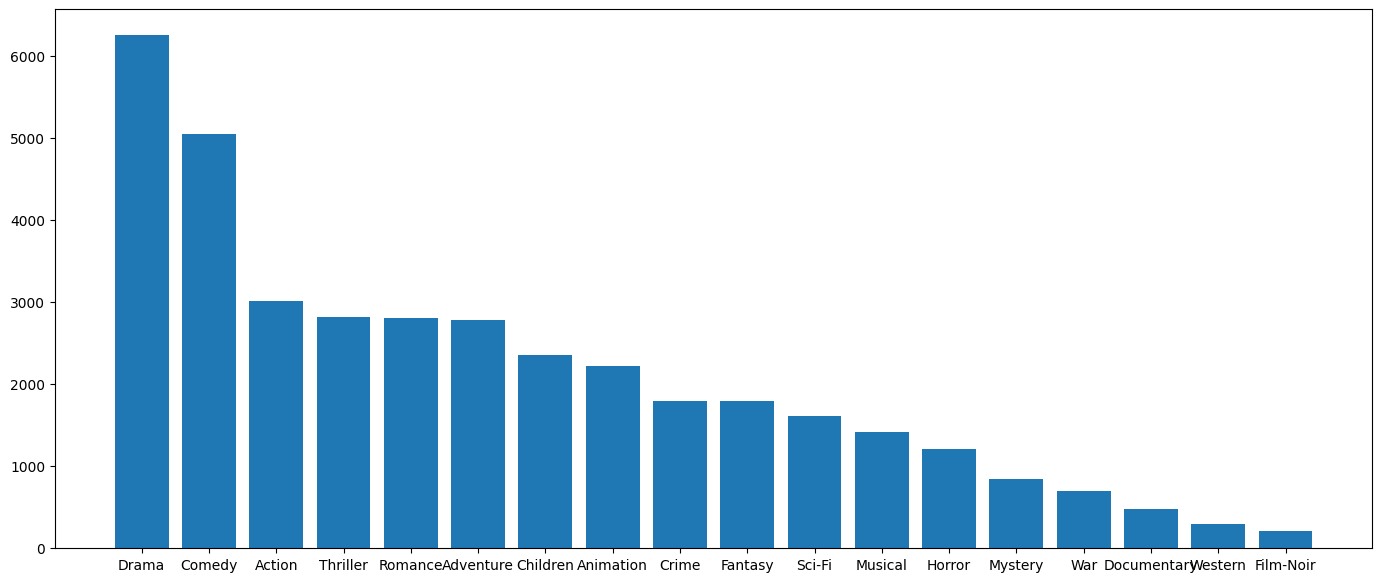

In [39]:
count_genre = movie.groupby("genre").count()["item"].sort_values(ascending=False)
plt.figure(figsize=(17, 7))
plt.bar(count_genre.index, count_genre)
plt.show()

#### 연도별 작품수

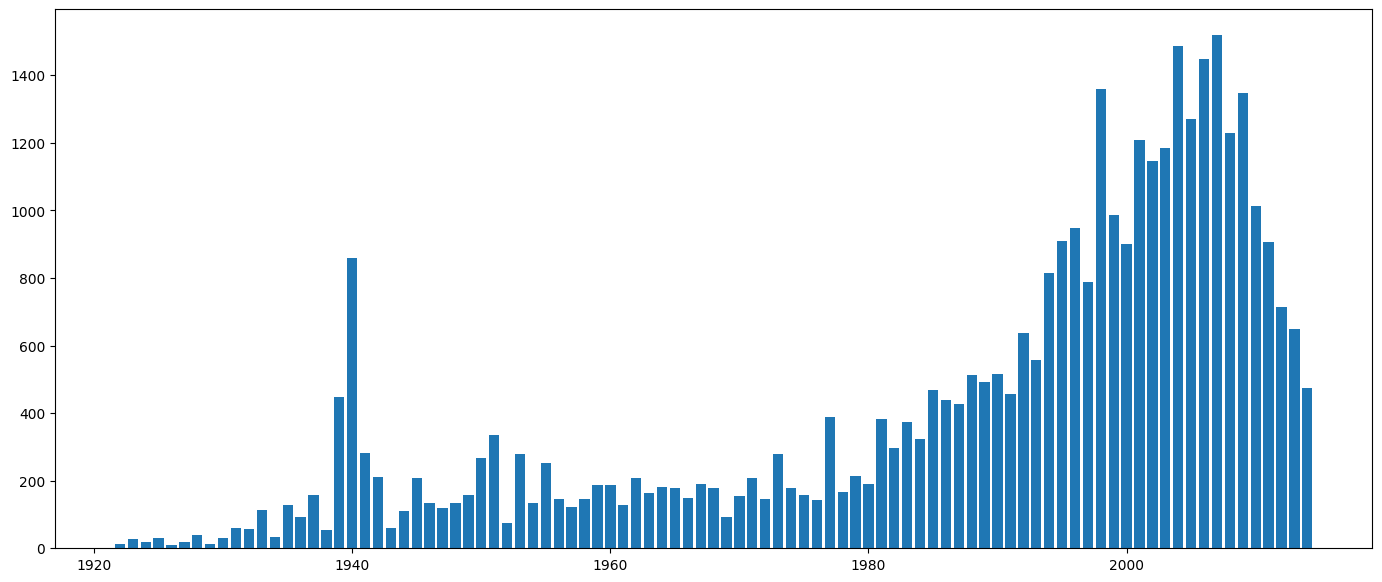

In [41]:
count_year = movie.groupby("year").count()["item"].sort_values(ascending=False)
plt.figure(figsize=(17, 7))
plt.bar(count_year.index, count_year)
plt.show()

### 1-2 합쳐진 데이터를 영화의 item id로 압축하기

In [42]:
grouped_movie = (
    movie.fillna(0)
    .groupby("item")
    .agg(set)
    .reset_index()
    .applymap(
        lambda x: (
            (list(x)[0] if len(list(x)) == 1 else list(x)) if isinstance(x, set) else x
        )
    )
)
grouped_movie = grouped_movie.replace([0], np.NaN)
grouped_movie["year"] = grouped_movie.year.fillna(0).astype("Int64").replace(0, np.NaN)
grouped_movie.head()

,item,director,count_director,genre,title,writer,count_writer,year
0,1,nm0005124,5.0,"[Comedy, Children, Animation, Adventure, Fantasy]",Toy Story (1995),"[nm0004056, nm0169505, nm0710020, nm0812513, n...","[5.0, 6.0, 8.0, 9.0, 10.0]",1995
1,2,nm0002653,9.0,"[Children, Adventure, Fantasy]",Jumanji (1995),"[nm0885575, nm0378144, nm0852430]","[2.0, 3.0, 7.0]",1995
2,3,nm0222043,7.0,"[Comedy, Romance]",Grumpier Old Men (1995),nm0425756,7.0,1995
3,4,nm0001845,3.0,"[Romance, Comedy, Drama]",Waiting to Exhale (1995),nm0060103,12.0,1995
4,5,nm0796124,4.0,Comedy,Father of the Bride Part II (1995),"[nm0583600, nm0329304, nm0796124, nm0352443]","[8.0, 9.0, 10.0]",1995


In [61]:
grouped_movie["genre"].value_counts()

Drama                                              832
Comedy                                             464
[Comedy, Drama]                                    308
[Romance, Drama]                                   297
[Comedy, Romance]                                  246
                                                  ... 
[Thriller, Crime, Comedy, Romance]                   1
[Fantasy, Sci-Fi, Comedy, Drama]                     1
[Children, Musical, Drama]                           1
[Mystery, Comedy, Children, Adventure, Fantasy]      1
[Action, Comedy, Animation]                          1
Name: genre, Length: 759, dtype: int64

### 1-3 train 데이터 시청시간

- time: datetime 데이터 타입
- duration: timedelta 데이터 타입

In [43]:
# unix time -> datetime : 실행시간 9초 내외
train['time'] = pd.to_datetime(train['time'], unit='s').dt.strftime('%Y-%m-%d %H:%M:%S')
train['time'] = pd.to_datetime(train['time'])

In [44]:
# duration
train['duration'] = train.sort_values('time').groupby('user').time.diff(-1).abs() # by index (no worry)

## 2. 결측치 탐색

In [47]:
isna = grouped_movie.isna().sum()
isna

item                 0
director          1304
count_director    1304
genre                0
title                0
writer            1159
count_writer      1159
year                 8
dtype: int64

### 2-1 director와 writer의 공통 결측치 탐색

In [48]:
tmp = grouped_movie[grouped_movie["director"].isna()]
tmp = tmp.isna().sum()
tmp

item                 0
director          1304
count_director    1304
genre                0
title                0
writer             629
count_writer       629
year                 2
dtype: int64

### 2-2 년도 결측치 채우기

In [49]:
year_isna = grouped_movie[grouped_movie["year"].isna()]
year_isna.head()

,item,director,count_director,genre,title,writer,count_writer,year
1847,3310,nm0000122,9.0,"[Comedy, Drama]","Kid, The (1921)",nm0000122,10.0,<NA>
3455,6987,NaN,NaN,"[Horror, Crime, Fantasy]","Cabinet of Dr. Caligari, The (Cabinet des Dr. ...",nm0562346,3.0,<NA>
3456,6988,nm0000428,3.0,"[Romance, Drama]",Broken Blossoms or The Yellow Man and the Girl...,nm0000428,3.0,<NA>
3513,7065,nm0000428,3.0,"[War, Drama]","Birth of a Nation, The (1915)","[nm0000428, nm0940488]","[2.0, 3.0]",<NA>
3605,7243,nm0000428,3.0,Drama,Intolerance: Love's Struggle Throughout the Ag...,"[nm0000428, nm0002616, nm0115218, nm0940488]","[2.0, 3.0, 5.0]",<NA>


In [50]:
grouped_movie["year"].fillna(
    grouped_movie["title"].apply(
        lambda x: (
            re.search(r"(\d{4})", x).group()
            if re.search(r"(\d{4})", x) and "year" in grouped_movie.columns
            else np.NaN
        )
    ),
    inplace=True,
)
grouped_movie.head()

,item,director,count_director,genre,title,writer,count_writer,year
0,1,nm0005124,5.0,"[Comedy, Children, Animation, Adventure, Fantasy]",Toy Story (1995),"[nm0004056, nm0169505, nm0710020, nm0812513, n...","[5.0, 6.0, 8.0, 9.0, 10.0]",1995
1,2,nm0002653,9.0,"[Children, Adventure, Fantasy]",Jumanji (1995),"[nm0885575, nm0378144, nm0852430]","[2.0, 3.0, 7.0]",1995
2,3,nm0222043,7.0,"[Comedy, Romance]",Grumpier Old Men (1995),nm0425756,7.0,1995
3,4,nm0001845,3.0,"[Romance, Comedy, Drama]",Waiting to Exhale (1995),nm0060103,12.0,1995
4,5,nm0796124,4.0,Comedy,Father of the Bride Part II (1995),"[nm0583600, nm0329304, nm0796124, nm0352443]","[8.0, 9.0, 10.0]",1995


In [51]:
check_year = pd.DataFrame()
for i in year_isna["item"].tolist():
    check_year = pd.concat(
        [check_year.loc[:], grouped_movie[grouped_movie["item"] == i]]
    )
check_year.head()

,item,director,count_director,genre,title,writer,count_writer,year
1847,3310,nm0000122,9.0,"[Comedy, Drama]","Kid, The (1921)",nm0000122,10.0,1921
3455,6987,NaN,NaN,"[Horror, Crime, Fantasy]","Cabinet of Dr. Caligari, The (Cabinet des Dr. ...",nm0562346,3.0,1920
3456,6988,nm0000428,3.0,"[Romance, Drama]",Broken Blossoms or The Yellow Man and the Girl...,nm0000428,3.0,1919
3513,7065,nm0000428,3.0,"[War, Drama]","Birth of a Nation, The (1915)","[nm0000428, nm0940488]","[2.0, 3.0]",1915
3605,7243,nm0000428,3.0,Drama,Intolerance: Love's Struggle Throughout the Ag...,"[nm0000428, nm0002616, nm0115218, nm0940488]","[2.0, 3.0, 5.0]",1916


## 3. 데이터 저장

### 3-1 train_ratings.csv에 grouped_movie 정보 merge

In [52]:
trains = pd.merge(train, grouped_movie, on="item", how="inner")
trains = trains.sort_values(by="user")
trains.head()

,user,item,time,duration,director,count_director,genre,title,writer,count_writer,year
0,11,4643,2009-01-01 04:02:09,0 days 00:00:05,nm0000318,17.0,"[Action, Adventure, Sci-Fi, Drama]",Planet of the Apes (2001),"[nm0742797, nm0099541, nm0465199, nm0115310]","[8.0, 9.0]",2001
324906,11,37830,2009-01-01 05:40:38,0 days 00:00:10,NaN,NaN,"[Sci-Fi, Animation, Action, Adventure, Fantasy]",Final Fantasy VII: Advent Children (2004),nm0756983,2.0,2004
325641,11,60040,2009-01-01 05:40:48,0 days 00:00:03,nm0504642,6.0,"[Action, Sci-Fi]","Incredible Hulk, The (2008)","[nm0672015, nm0456158, nm0498278]","[16.0, 10.0, 15.0]",2008
327148,11,34319,2009-01-01 05:40:51,0 days 00:00:22,nm0000881,11.0,"[Thriller, Action, Sci-Fi]","Island, The (2005)","[nm1047021, nm0649460, nm0476064]","[10.0, 2.0]",2005
329565,11,8644,2009-01-01 05:41:13,0 days 00:00:05,nm0001639,4.0,"[Thriller, Action, Adventure, Sci-Fi]","I, Robot (2004)","[nm0899113, nm0001920, nm0326040]","[2.0, 12.0]",2004


### 3-2 trains의 결측치

In [53]:
train_isna = trains.isna().sum()
train_isna

user                   0
item                   0
time                   0
duration           31360
director          301445
count_director    301445
genre                  0
title                  0
writer            312692
count_writer      312692
year                   0
dtype: int64

### 3-3 trains 데이터의 공통 결측치 탐색

In [54]:
tmp = trains[trains["writer"].isna()]
tmp = tmp.isna().sum()
tmp

user                   0
item                   0
time                   0
duration            2403
director          118851
count_director    118851
genre                  0
title                  0
writer            312692
count_writer      312692
year                   0
dtype: int64

### 3-3 movie 정보와 user_movie interaction 정보 저장

In [55]:
grouped_movie.to_csv(data_dir + "movie.csv", index=False)
trains.to_csv(data_dir + "user_movie.csv", index=False)